In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

## Load and preprocess data

In [ ]:
# Load and preprocess data
def prepare_data(df, feature_col='Open', seq_length=10):
    scaler = MinMaxScaler()
    df[feature_col] = scaler.fit_transform(df[[feature_col]])
    
    X, y = [], []
    for i in range(len(df) - seq_length):
        X.append(df[feature_col].iloc[i:i+seq_length].values)
        y.append(df[feature_col].iloc[i+seq_length])
    
    return np.array(X), np.array(y), scaler

## Load data

In [14]:
df = pd.read_csv("NVDA.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)

## Prepare dataset

In [15]:
list(df.columns)

['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']

In [ ]:
seq_length = 10  # Number of days for LSTM input
scalers = {}  # Dictionary to store scalers for each column
X_dict, y_dict = {}, {}  # Dictionaries to store X and y for each column

for col in df.columns:
    if col != 'Date':  # Skip the 'Date' column
        X, y, scaler = prepare_data(df, feature_col=col, seq_length=seq_length)
        X = X.reshape((X.shape[0], X.shape[1], 1))  # Reshaping for LSTM
        X_dict[col] = X
        y_dict[col] = y
        scalers[col] = scaler

# Convert to PyTorch tensors

In [11]:
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

## Train-Test-Validation Split

In [12]:
X_train, X_temp, y_train, y_temp = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

## Create DataLoader

In [13]:
batch_size = 16
train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)
test_data = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

## Define LSTM model

In [8]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, output_size=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out[:, -1, :])

## Initialize model

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMModel().to(device)

## Define loss and optimizer

In [10]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0015)

## Training loop with validation

In [11]:
epochs = 50
train_losses, val_losses = [], []
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            y_val_pred = model(X_val_batch)
            val_loss += criterion(y_val_pred, y_val_batch).item()
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")


Epoch 1/50, Train Loss: 0.004056, Val Loss: 0.000123
Epoch 2/50, Train Loss: 0.000399, Val Loss: 0.000225
Epoch 3/50, Train Loss: 0.000315, Val Loss: 0.000130
Epoch 4/50, Train Loss: 0.000308, Val Loss: 0.000186
Epoch 5/50, Train Loss: 0.000236, Val Loss: 0.000060
Epoch 6/50, Train Loss: 0.000243, Val Loss: 0.000237
Epoch 7/50, Train Loss: 0.000281, Val Loss: 0.000214
Epoch 8/50, Train Loss: 0.000227, Val Loss: 0.000254
Epoch 9/50, Train Loss: 0.000212, Val Loss: 0.000168
Epoch 10/50, Train Loss: 0.000256, Val Loss: 0.000053
Epoch 11/50, Train Loss: 0.000189, Val Loss: 0.000212
Epoch 12/50, Train Loss: 0.000227, Val Loss: 0.000085
Epoch 13/50, Train Loss: 0.000148, Val Loss: 0.000074
Epoch 14/50, Train Loss: 0.000173, Val Loss: 0.000074
Epoch 15/50, Train Loss: 0.000182, Val Loss: 0.000100
Epoch 16/50, Train Loss: 0.000172, Val Loss: 0.000040
Epoch 17/50, Train Loss: 0.000147, Val Loss: 0.000039
Epoch 18/50, Train Loss: 0.000164, Val Loss: 0.000039
Epoch 19/50, Train Loss: 0.000154, Va

### Save model

In [12]:
# torch.save(model.state_dict(), "lstm_nvidia_model.pth")
torch.save(model.state_dict(), "lstm_nvidia_model2.pth")

## Plot training and validation loss

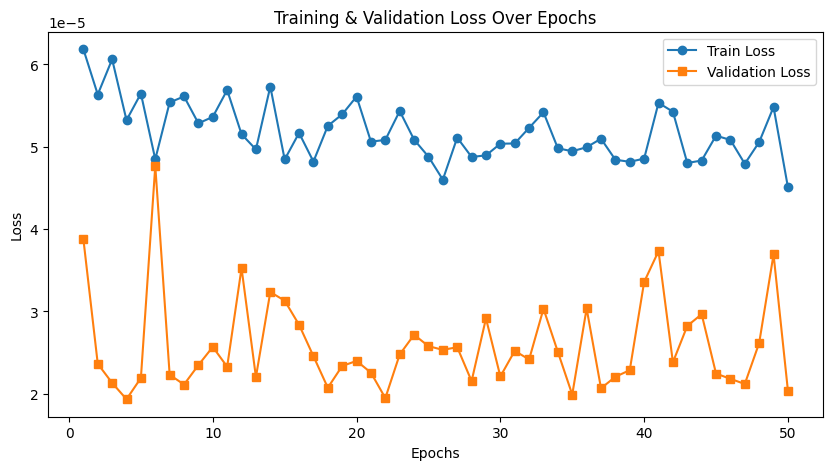

In [26]:
plt.figure(figsize=(10,5))
plt.plot(range(1, epochs+1), train_losses, label='Train Loss', marker='o', linestyle='-')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss', marker='s', linestyle='-')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Over Epochs")
plt.legend()
plt.show()

## Load trained model

In [13]:

model.load_state_dict(torch.load(r"lstm_nvidia_model2.pth"))
model.eval()

LSTMModel(
  (lstm): LSTM(1, 50, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

## Predictions

In [14]:
predictions, actuals = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_pred = model(X_batch)
        predictions.append(y_pred.cpu().numpy())
        actuals.append(y_batch.numpy())

## Convert to original scale

In [15]:
predictions = scaler.inverse_transform(np.vstack(predictions))
actuals = scaler.inverse_transform(np.vstack(actuals))

## Plot actual vs predicted with transparency

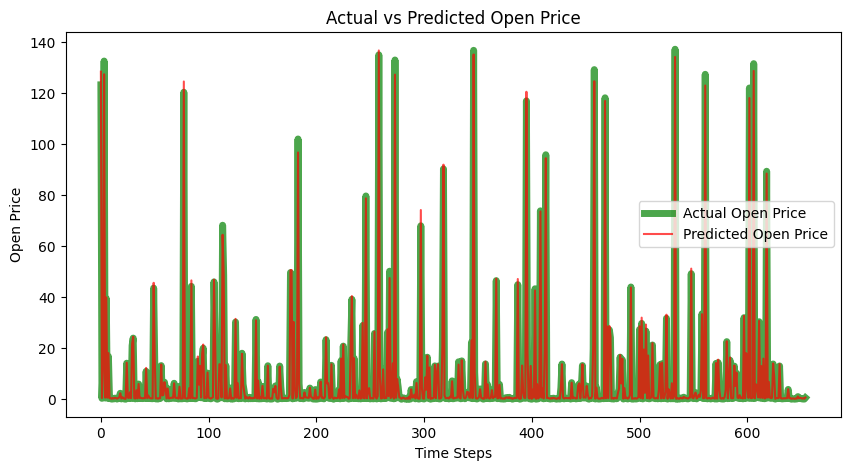

In [16]:
plt.figure(figsize=(10,5))
plt.plot(actuals, label='Actual Open Price', color='g', alpha=0.7,linewidth=5)  # Added alpha for transparency
plt.plot(predictions, label='Predicted Open Price', color='r', alpha=0.7)  # Added alpha for transparency
plt.legend()
plt.title("Actual vs Predicted Open Price")
plt.xlabel("Time Steps")
plt.ylabel("Open Price")
plt.show()

## Model evaluation

In [17]:
mse = np.mean((actuals - predictions) ** 2)
mae = np.mean(np.abs(actuals - predictions))
print(f"Test MSE: {mse:.6f}, Test MAE: {mae:.6f}")

Test MSE: 0.606198, Test MAE: 0.330728


## Identify failure cases

In [18]:
error_threshold = np.percentile(np.abs(actuals - predictions), 90)
failure_cases = np.where(np.abs(actuals - predictions) > error_threshold)[0]

## Failure Cases in Predictions

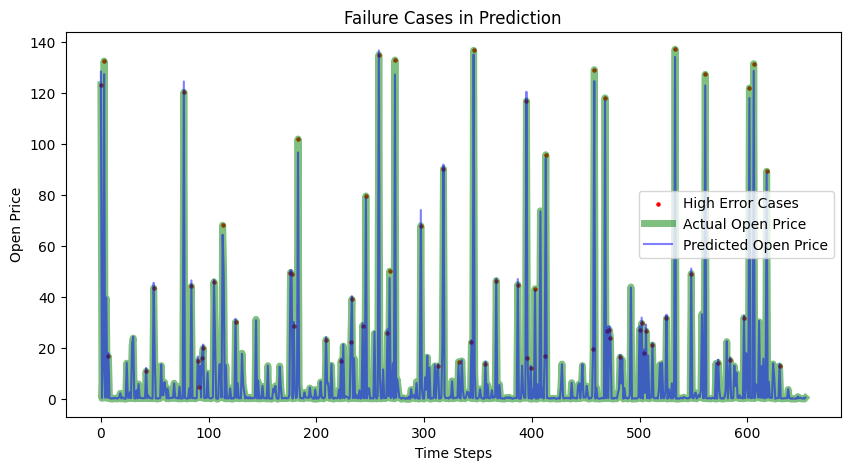

In [19]:
plt.figure(figsize=(10,5))
plt.scatter(failure_cases, actuals[failure_cases], color='r', label='High Error Cases',s=5)
plt.plot(actuals, label='Actual Open Price', color='g', alpha=0.5, linewidth=5)
plt.plot(predictions, label='Predicted Open Price', color='b', alpha=0.5)
plt.legend()
plt.title("Failure Cases in Prediction")
plt.xlabel("Time Steps")
plt.ylabel("Open Price")
plt.show()

In [20]:
for idx in failure_cases:
    print(f"Failure Case {idx}:")
    print(f"Input Sequence: {X[idx]}")
    print(f"Actual: {actuals[idx]}, Predicted: {predictions[idx]}")

Failure Case 0:
Input Sequence: [[5.78711203e-05]
 [6.12764646e-05]
 [7.14859352e-05]
 [4.59557062e-05]
 [4.42563054e-05]
 [4.34000754e-05]
 [3.06349675e-05]
 [3.06349675e-05]
 [1.19154206e-05]
 [2.38308151e-05]]
Actual: [123.240005], Predicted: [128.39879]
Failure Case 3:
Input Sequence: [[4.59557062e-05]
 [4.42563054e-05]
 [4.34000754e-05]
 [3.06349675e-05]
 [3.06349675e-05]
 [1.19154206e-05]
 [2.38308151e-05]
 [3.82953369e-05]
 [4.34000754e-05]
 [3.74456299e-05]]
Actual: [132.58], Predicted: [127.41059]
Failure Case 7:
Input Sequence: [[3.06349675e-05]
 [1.19154206e-05]
 [2.38308151e-05]
 [3.82953369e-05]
 [4.34000754e-05]
 [3.74456299e-05]
 [2.21248912e-05]
 [2.04254708e-05]
 [4.42563054e-05]
 [6.12764646e-05]]
Actual: [16.788], Predicted: [18.107296]
Failure Case 42:
Input Sequence: [[3.06349675e-05]
 [2.97852606e-05]
 [3.74456299e-05]
 [6.55315158e-05]
 [6.63811966e-05]
 [4.93610440e-05]
 [5.95705146e-05]
 [4.76616497e-05]
 [4.51060189e-05]
 [3.74456299e-05]]
Actual: [10.970999],

## Interpreting models using SHAP

### Sequence Level

SHAP (SHapley Additive exPlanations) is a framework for interpreting machine learning models by explaining the contribution of each feature to a model's predictions. It is based on Shapley values from cooperative game theory, which fairly distribute the "payout" (model prediction) among the "players" (features). 

Key features of SHAP:
1. **Global Interpretability**: It provides insights into which features are most important across the entire dataset.
2. **Local Interpretability**: It explains individual predictions by showing how each feature contributes positively or negatively to the output.
3. **Visualization Tools**: SHAP includes plots like summary plots, force plots, and dependence plots to make explanations intuitive and accessible.

SHAP is widely used for debugging, feature importance analysis, and ensuring transparency in machine learning models.

This code snippet uses the **SHAP** (SHapley Additive exPlanations) library to compute feature importance values for a machine learning model. Here's a breakdown:

1. **`model.eval()`**: Temporarily sets the model to evaluation mode. This is important for models like neural networks, as it disables behaviors like dropout and batch normalization that are only used during training.

2. **`shap.GradientExplainer`**: Creates a SHAP explainer object using the `GradientExplainer`, which is suitable for models that use gradients (e.g., neural networks). It takes the model and the training data (`X_train`) as inputs. The `to(device)` ensures the data is moved to the same device (CPU/GPU) as the model.

3. **`model.train()`**: Switches the model back to training mode after the SHAP explainer is initialized. This ensures the model is ready for further training if needed.

4. **`explainer.shap_values(X_test.to(device))`**: Computes the SHAP values for the test dataset (`X_test`). These values explain the contribution of each feature in the input data to the model's predictions.

In [21]:
import shap

# Temporarily set the model to evaluation mode for SHAP
model.eval()

# Use GradientExplainer instead of DeepExplainer
explainer = shap.GradientExplainer(model, X_train.to(device))

# Compute SHAP values
model.train()
shap_values = explainer.shap_values(X_test.to(device))

C:\Users\dheen\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


This cell is primarily focused on visualizing feature importance and understanding the contributions of individual features to the model's predictions.

1. **Flattening `X_test`**:  
   The `X_test` tensor, which contains the test dataset, is reshaped into a 2D array using `.view(X_test.shape[0], -1)`. This ensures that all features are flattened into a single dimension for each sample. The `.cpu().numpy()` converts the PyTorch tensor into a NumPy array, which is required for SHAP's utilities.

2. **SHAP Summary Plot**:  
   The `shap.summary_plot` function generates a bar chart summarizing the SHAP values (`shap_values`). This plot ranks features by their average importance in the model's predictions. The `plot_type="bar"` specifies a bar chart, and `show=True` ensures the plot is displayed immediately.

C:\Users\dheen\AppData\Local\Temp\ipykernel_4424\2462817167.py:8: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_flat, X_test_flat, plot_type="bar", show=True)


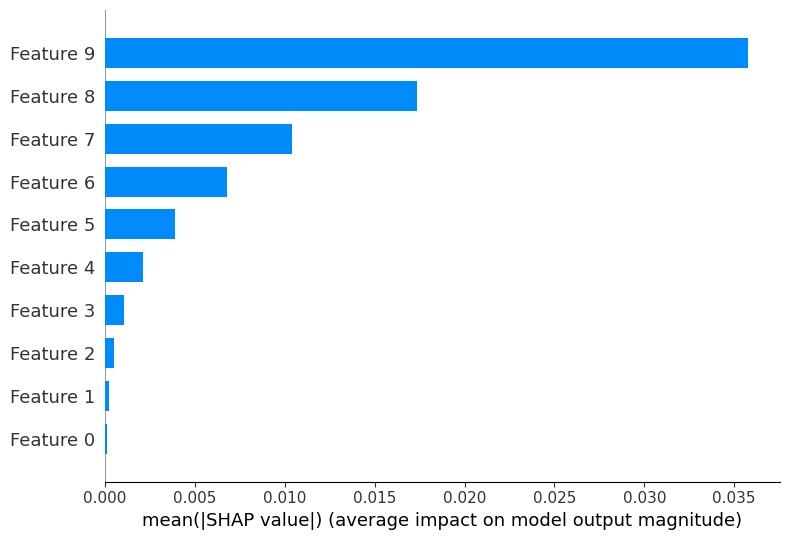

In [23]:
# Flatten X_test to 2D for shap.utils.hclust
X_test_flat = X_test.view(X_test.shape[0], -1).cpu().numpy()

# Flatten shap_values to match the shape of X_test_flat
shap_values_flat = shap_values.reshape(shap_values.shape[0], -1)

# Generate summary plot
shap.summary_plot(shap_values_flat, X_test_flat, plot_type="bar", show=True)

This horizontal bar plot, generated using SHAP values, illustrates the average impact of each feature on the magnitude of the model's output across the entire dataset used for the explanation. Each bar represents a different feature, and the length of the bar corresponds to the mean absolute SHAP value for that feature.

In essence, the longer the bar for a particular feature, the more significant that feature is, on average, in influencing the model's predictions, regardless of the direction of that influence (whether it tends to increase or decrease the output). This plot helps us understand the global feature importance as determined by the SHAP framework.

Looking at the plot, we can observe a clear ranking of feature importance:

Feature 9 has by far the longest bar, indicating that it is the most important feature, on average, in determining the model's output magnitude. Changes in Feature 9 have the largest overall impact on the model's predictions.
Feature 8 is the next most important feature, though its average impact is considerably smaller than that of Feature 9.
Feature 7 and Feature 6 show a similar level of importance, with their average impact being less than Feature 8 but still relatively substantial compared to the remaining features.
Features 4, 5, 3, 2, 1, and 0 have progressively shorter bars, suggesting that they have a smaller average impact on the model's output magnitude compared to the top few features. Feature 0 appears to have the least average impact.
Therefore, this plot highlights that the model's predictions are, on average, most sensitive to changes in Feature 9, followed by Feature 8, then Features 7 and 6, with the remaining features having a comparatively smaller overall influence on the model's output magnitude across the dataset. This provides a global perspective on feature importance as learned by the model.

This cell is focused on visualizing and understanding the contributions of individual features to a specific prediction.

1. **Calculate the Expected Value**:  
   The model is set to evaluation mode using `model.eval()`, and the expected value of the model's predictions is calculated as the mean of the predictions on the training dataset (`X_train`). This value serves as the baseline for SHAP explanations.

2. **Generate Feature Names**:  
   A list of feature names is dynamically created based on the number of features in the flattened test dataset (`X_test_flat`). Each feature is labeled as "Feature 0", "Feature 1", etc.

3. **Create SHAP Explanation Object**:  
   The `shap.Explanation` object is constructed using the SHAP values (`shap_values[0]`), the calculated baseline (`expected_value`), the test data (`X_test_flat`), and the feature names. This object encapsulates all the information needed for SHAP visualizations.

4. **Generate Force Plot**:  
   The `shap.force_plot` function creates a force plot for a specific instance (e.g., the first instance in the test set). This plot visually explains how each feature contributes to the model's prediction for that instance. The `shap.initjs()` initializes JavaScript for rendering the plot in a Jupyter Notebook.

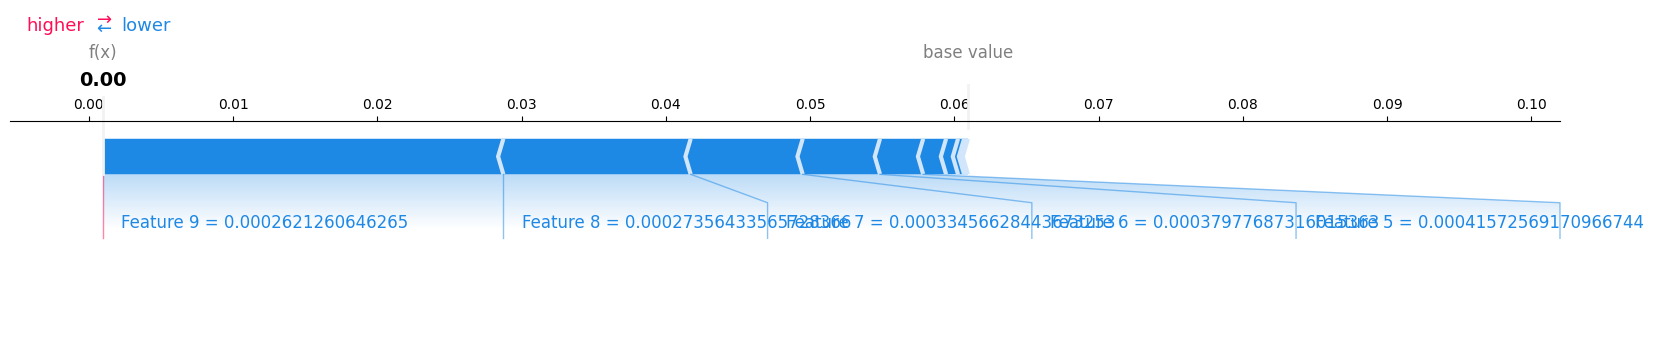

In [33]:
# Calculate the expected value manually
model.eval()
expected_value = model(X_train.to(device)).mean().item()

feature_names = [f"Feature {i}" for i in range(X_test_flat.shape[1])]

# Convert shap_values into an Explanation object
shap_explanation = shap.Explanation(values=shap_values_flat, base_values=expected_value, data=X_test_flat, feature_names=feature_names)

# Generate force plot for a specific instance (e.g., the first instance in the test set)
shap.initjs()
shap.force_plot(shap_explanation.base_values, shap_explanation.values[10], 
                shap_explanation.data[10], feature_names=feature_names, show = True, matplotlib=True)

The SHAP force plot provides a detailed, instance-level explanation of the model's prediction. The plot visualizes the contribution of each feature to the final predicted value of 0.84, relative to the average prediction of the model (the base value). Features displayed in red (such as Feature 3, Feature 5, and particularly Feature 7) indicate that their specific values for this instance pushed the prediction higher than the base value. Conversely, features displayed in blue (Feature 8 and Feature 9) indicate that their values pushed the prediction lower. The length of each bar corresponds to the magnitude of the feature's impact. In this case, Feature 7 exhibited the strongest positive influence, while Feature 8 had the most substantial negative impact. The final prediction of 0.84 is the result of the cumulative effect of these positive and negative feature contributions. This visualization offers a transparent view into the factors driving the model's output for this specific observation.

### For Failure Cases

In [44]:
X_failure = X[failure_cases]
y_failure_actual = y[failure_cases]
y_failure_pred = predictions[failure_cases]

In [49]:
import shap
from xgboost import train
model.eval()  # Ensure the model is in evaluation mode
# Ensure the input data has the correct shape (e.g., [batch_size, seq_length, num_features])
X_train_reshaped = torch.tensor(X_train, dtype=torch.float32).to(device).view(-1, seq_length, 1)
X_failure_reshaped = torch.tensor(X_failure, dtype=torch.float32).to(device).view(-1, seq_length, 1)

# Initialize the SHAP explainer and compute SHAP values
model.train()
explainer = shap.GradientExplainer(model, X_train_reshaped)
model.train()
shap_values_failure = explainer.shap_values(X_failure_reshaped)

C:\Users\dheen\AppData\Local\Temp\ipykernel_4424\3631530211.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_reshaped = torch.tensor(X_train, dtype=torch.float32).to(device).view(-1, seq_length, 1)


In [63]:

model.eval()
expected_value = model(X_train_reshaped).mean().item()

# Flatten X_failure to 2D for shap.utils.hclust
X_failure_flat = X_failure_reshaped.view(X_failure_reshaped.shape[0], -1).cpu().numpy()

# Flatten shap_values_failure to match the shape of X_failure_flat
shap_values_failure_flat = np.array(shap_values_failure).reshape(len(failure_cases), -1)

# Convert shap_values into an Explanation object
shap_explanation = shap.Explanation(values=shap_values_failure_flat, base_values=expected_value, data=X_failure_flat)

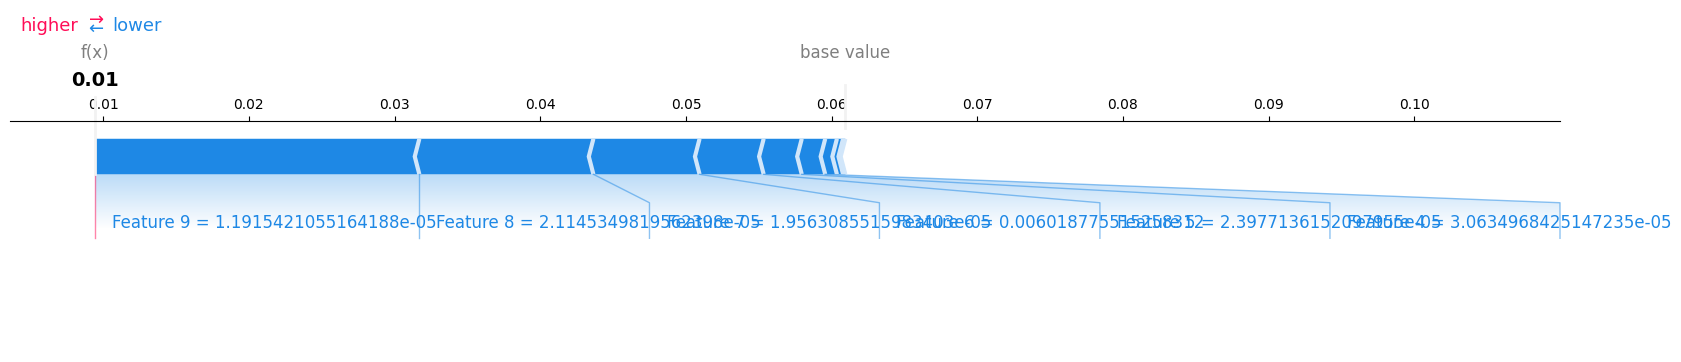

In [ ]:
# Ensure the SHAP values and data are flattened to match dimensions
shap_values_flat = shap_explanation.values.reshape(shap_explanation.data.shape[0], -1)
data_flat = shap_explanation.data.reshape(shap_explanation.data.shape[0], -1)

feature_names_failure = [f"Feature {i}" for i in range(X_failure_flat.shape[1])]
shap_explanation.feature_names = feature_names_failure
# Generate the force plot for a specific instance (e.g., the 10th instance)
shap.force_plot(shap_explanation.base_values, shap_values_flat[10], 
                data_flat[10], feature_names = feature_names_failure, show=True, matplotlib=True)

#generate summary plot for failure cases
shap.summary_plot(shap_values_failure_flat, X_failure_flat, plot_type="bar", show=True)

C:\Users\dheen\AppData\Local\Temp\ipykernel_4424\18678913.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_failure_flat, X_failure_flat, show=True)


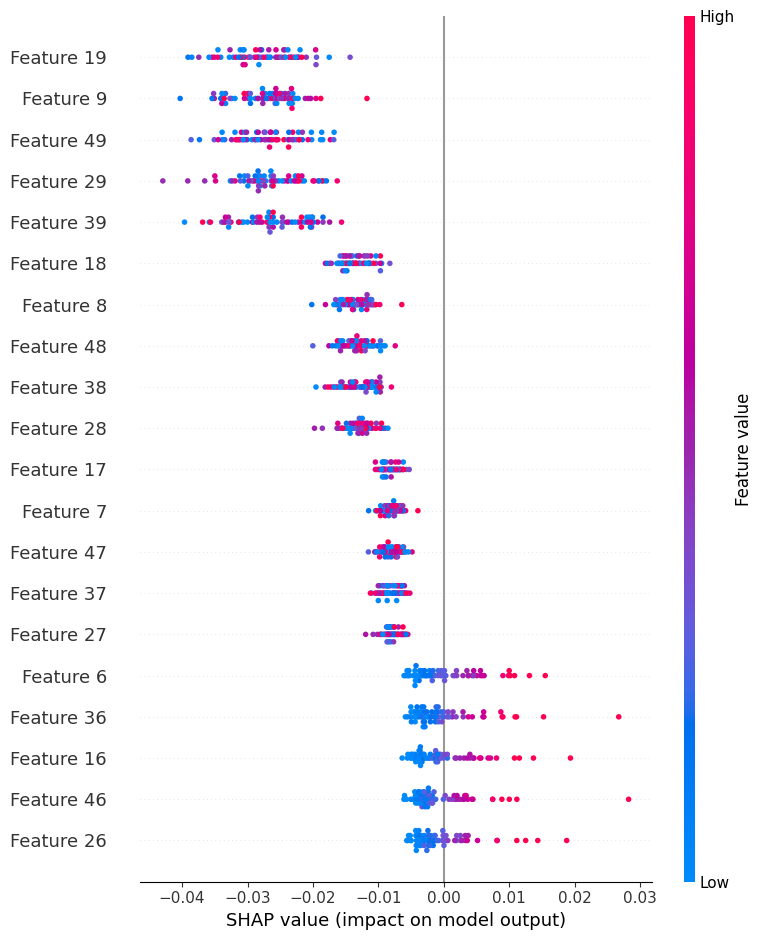

In [72]:
shap.summary_plot(shap_values_failure_flat, X_failure_flat, show=True)